# Brazilian House Rent Price

After taking a look at the data, I've decided that the houses_to_rentv1 is pretty much unusable for me. So I'll use the v2, and decide to predict the most useful-looking value: Rent amount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Setup

Setup time. We load all of the necessary libraries and the data.

In [ ]:
# General libraries import
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Import the scikit-learn methods and models here

# RandomForest, basically a lot of DecisionTree
from sklearn.ensemble import RandomForestRegressor
# train-test-split: splitting the data into a train set, and a test set
# to better evaluate the data
from sklearn.model_selection import train_test_split
# SimpleImputer, to preprocess missing data
from sklearn.impute import SimpleImputer
# Pipeline, to better implement workflow with steps
from sklearn.pipeline import Pipeline
# cross-validate: splitting the data into "folds" 
# to better reflect true performance
from sklearn.model_selection import cross_validate
# GridSearchCV, to help with hyperparameters tuning
from sklearn.model_selection import GridSearchCV

In [ ]:
# Load data
data = pd.read_csv("https://raw.githubusercontent.com/menamerai/vssr-2020/master/datasets_554905_1035602_houses_to_rent_v2.csv").drop(["total (R$)"], axis=1)
data.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11


# Data Inference

Now we'll look at the raw data, and use statistical methods and analysis to infer meaning and decide what to visualize, and what to use for the ML process.

In [ ]:
X_labels = ["city", "area", "rooms", "bathroom", "parking spaces", "floor", "animal", "furniture", "hoa (R$)", "fire insurance (R$)", "property tax (R$)"]
data.dropna()
# Training columns are traditionally named X (X is capital because it relfects that it is a vector)
X = data[X_labels]
# Target columns are traditionally named y
y = data["rent amount (R$)"]

In [ ]:
data.describe()

,area,rooms,bathroom,parking spaces,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
count,10692.000000,10692.000000,10692.000000,10692.000000,1.069200e+04,10692.000000,10692.000000,10692.000000
mean,149.217920,2.506079,2.236813,1.609147,1.174022e+03,3896.247194,366.704358,53.300879
std,537.016942,1.171266,1.407198,1.589521,1.559231e+04,3408.545518,3107.832321,47.768031
min,11.000000,1.000000,1.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000
25%,56.000000,2.000000,1.000000,0.000000,1.700000e+02,1530.000000,38.000000,21.000000
50%,90.000000,2.000000,2.000000,1.000000,5.600000e+02,2661.000000,125.000000,36.000000
75%,182.000000,3.000000,3.000000,2.000000,1.237500e+03,5000.000000,375.000000,68.000000
max,46335.000000,13.000000,10.000000,12.000000,1.117000e+06,45000.000000,313700.000000,677.000000


In [ ]:
# The groupby function: group the data by a column then perform a statistical operation
# Other operations include .count(), .std(), meadian(),...
data.groupby(["city"]).mean()

,area,rooms,bathroom,parking spaces,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
city,,,,,,,,
Belo Horizonte,207.411765,3.020668,2.402226,1.955485,2324.197138,3664.127981,272.782194,53.675676
Campinas,137.561547,2.355217,1.960141,1.558030,628.922626,2364.290739,147.657679,32.388042
Porto Alegre,103.609388,2.140821,1.725901,1.044426,491.618609,2337.699916,124.021794,36.425817
Rio de Janeiro,105.347768,2.243837,1.756163,0.744171,1079.432378,3232.904064,256.853431,42.483011
São Paulo,158.899439,2.558859,2.467641,1.877527,1169.627994,4652.793783,495.701716,62.428911


**Conclusion**
> Because this dataset seems pretty much impossible to pin down when simply looking at the raw data, I concluse that this would be a great dataset to train on, and would be of use in real life. 

And thus, we move to the visualization part for better inference

# Data Visualization

We begin with general and mass visualization, then move on to more specific cases and pairs

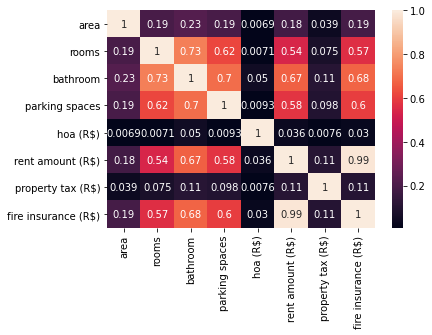

In [ ]:
# The heatmap doesn't really take in a dataframe
# So we use the .corr() to draw a correlation matrix from a dataframe
sns.heatmap(data.corr(), annot=True)

Hmm... It seems that the homeowner tax and the property tax has little to do with anything else, creating a clear black mark. I'll drop them.

In [ ]:
X = X.drop(["hoa (R$)", "property tax (R$)"], axis=1)
X.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,fire insurance (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,42
1,São Paulo,320,4,4,0,20,acept,not furnished,63
2,Porto Alegre,80,1,1,1,6,acept,not furnished,41
3,Porto Alegre,51,2,1,0,2,acept,not furnished,17
4,São Paulo,25,1,1,0,1,not acept,not furnished,11


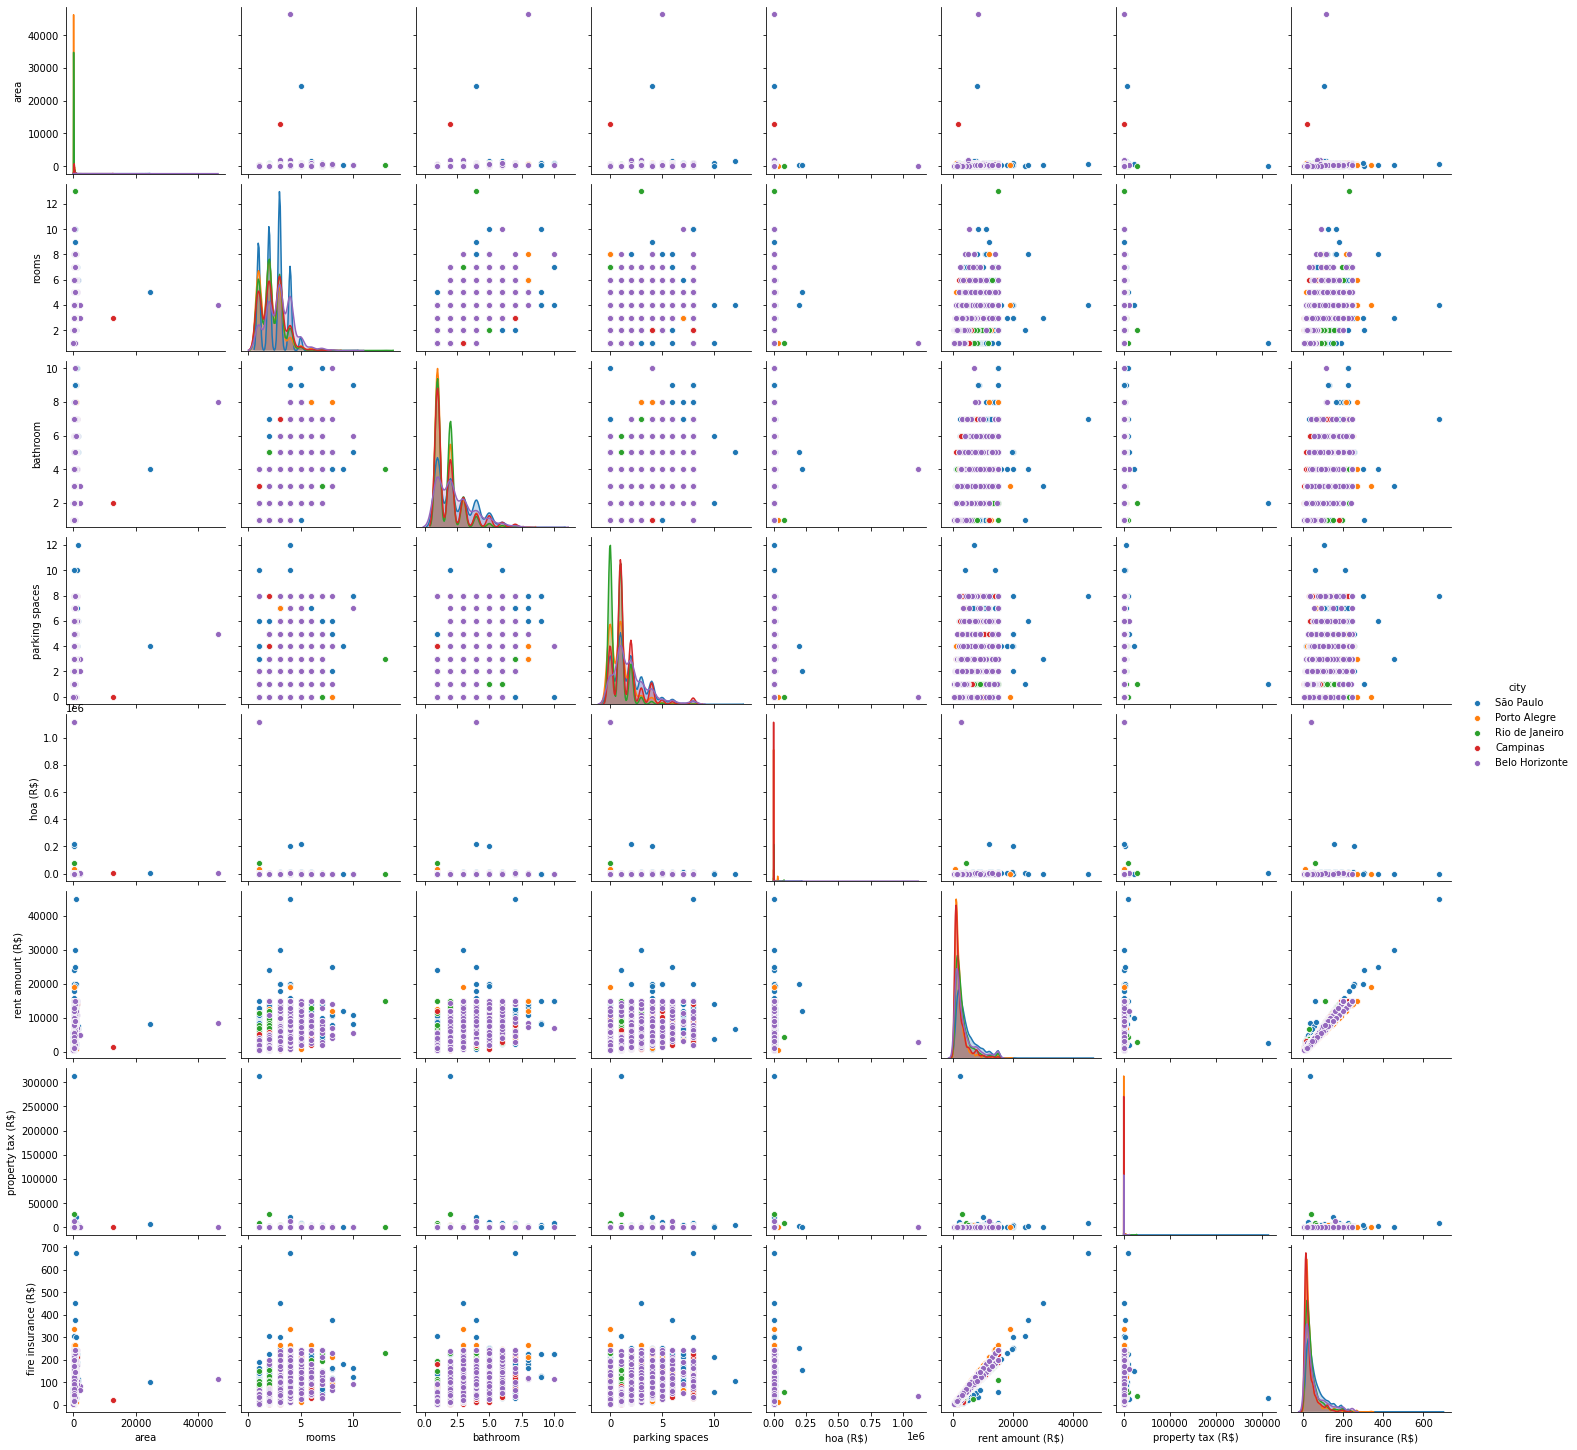

In [ ]:
# pairplot plots every single data columns in pair with each others in scatterplots and kdeplots
sns.pairplot(data=data, hue="city")

# Data Manipulation

Time to change up the data a bit so the model can better infer from it. First step is to convert every string value to integers.

In [ ]:
# These are the string values we want to convert to numberical data
print(X["city"].unique())
print(X["animal"].unique())
print(X["furniture"].unique())

['São Paulo' 'Porto Alegre' 'Rio de Janeiro' 'Campinas' 'Belo Horizonte']
['acept' 'not acept']
['furnished' 'not furnished']


In [ ]:
# Check for missing values
print(X["floor"].unique()) # The missing value here seems to be labeled "-"
# I checked the other columns. Seems to be all fine

['7' '20' '6' '2' '1' '-' '4' '3' '10' '11' '24' '9' '8' '17' '18' '5'
 '13' '15' '16' '14' '26' '12' '21' '19' '22' '27' '23' '35' '25' '46'
 '28' '29' '301' '51' '32']


There are 5 unique cities, so it should work ok.
* Sao Paulo = 1
* Porto Alegre = 2
* Rio = 3
* Campinas = 4
* Belo Horizonte = 5

There are also two different values in the animal column and the furniture column, and the "-" thing in the floor. I will assume it means no data and drop the columns with it.

In [ ]:
# Run this only once, please
"""
These are lambdas. They are like annonymous functions,
or like (x) => in JavaScript as far as I'm aware.
We basically apply a lambda to every item in a column using .apply(),
then use Python ternary operators to change them according to their values
(check https://book.pythontips.com/en/latest/ternary_operators.html for ternary operators use)
Together, the .apply() and the lambda works the same as the .map() in JavaScript,
which is a totally awesome method, you should check it out
if you're working with React, or is a JavaScript dev in general
(though I doubt anyone working with React and the like would not know of it
https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Global_Objects/Array/map)
"""
X["city"] = X["city"].apply(lambda x: 1 if x == "São Paulo" 
                            else 2 if x == "Porto Alegre" 
                            else 3 if x == "Rio de Janeiro"
                            else 4 if x =="Campinas" else 5)
X["animal"] = X["animal"].apply(lambda x: 1 if x == "acept" else 0) # Gosh the hell is acept
X["furniture"] = X["furniture"].apply(lambda x: 1 if x == "furnished" else 0)
# I'm converting the "-" value into NaN for easier SimpleImputer use
X["floor"] = X["floor"].apply(lambda x: np.nan if x == "-" else x)

In [ ]:
X.tail()
# See? The NaN is there, so this is working fine

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,fire insurance (R$)
10687,2,63,2,1,1,5,0,1,22
10688,1,285,4,4,4,17,1,0,191
10689,3,70,3,3,0,8,0,1,78
10690,3,120,2,2,2,8,1,1,155
10691,1,80,2,1,0,NaN,1,0,22


In [ ]:
y.tail()

10687     1478
10688    15000
10689     6000
10690    12000
10691     1400
Name: rent amount (R$), dtype: int64

... and all done! Now the fun part.

# Machine Learning

Here we go. I have decided to use RandomForestRegressor as my model, as the XGBoost models are too much work.
First we split the dataset.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)
print("There are {} samples in the training set and {} samples in the test set".format(X_train.shape[0], X_test.shape[0]))

There are 8553 samples in the training set and 2139 samples in the test set


This was the place for gridsearch. Now I no longer needs this because I've got the best parameters via this, and self experimentation.

In [ ]:
"""
pipeline = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                            ("model", RandomForestRegressor(random_state=1))])
grid_params = {
    "model__n_estimators": [140, 160, 180],
    "model__criterion": ["mse"],
    "model__bootstrap": [False],
    "model__max_depth": list(range(5, 21, 5))
}
grid_search = GridSearchCV(estimator=pipeline, param_grid=grid_params, cv=3, verbose=1)
grid_search.fit(X_train, y_train)
grid_search.best_params_
"""

'\npipeline = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),\n                            ("model", RandomForestRegressor(random_state=1))])\ngrid_params = {\n    "model__n_estimators": [140, 160, 180],\n    "model__criterion": ["mse"],\n    "model__bootstrap": [False],\n    "model__max_depth": list(range(5, 21, 5))\n}\ngrid_search = GridSearchCV(estimator=pipeline, param_grid=grid_params, cv=3, verbose=1)\ngrid_search.fit(X_train, y_train)\ngrid_search.best_params_\n'

# Mean Squared Error Model

In [ ]:
final_model = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                            ("model", RandomForestRegressor(random_state=1,
                                                            bootstrap=False, 
                                                            criterion="mse",
                                                            n_estimators=180,
                                                            max_depth=7))])
scores = cross_validate(final_model, X_train, y_train, cv=3, scoring="neg_root_mean_squared_error")
print(-scores["test_score"].mean())

384.1217754537035


# Mean Absolute Error Model

In [ ]:
final_model_mae = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                            ("model", RandomForestRegressor(random_state=1,
                                                            bootstrap=False, 
                                                            criterion="mae",
                                                            n_estimators=60,
                                                            max_depth=16))])
scores_mae = cross_validate(final_model_mae, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")
print(-scores_mae["test_score"].mean())

121.42491913168868


# Mini Model 

This predicts the rent price using fire insurance price, and the location of the place.

In [ ]:
final_model_mae_fire = Pipeline(steps=[("preprocess", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                            ("model", RandomForestRegressor(random_state=1,
                                                            bootstrap=False, 
                                                            criterion="mse",
                                                            n_estimators=200,
                                                            max_depth=15))])
scores_mae_fire = cross_validate(final_model_mae_fire, X_train[["fire insurance (R$)", "city"]], y_train, cv=3, scoring="neg_root_mean_squared_error")
print(-scores_mae_fire["test_score"].mean())

392.7886484253622
